# Graded Questions Time Series II

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
data = pd.read_csv('UNRATE.csv',header=None,names=['Date','Unrate'])
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.set_index('Date',inplace=True)
data.head()

,Unrate
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [15]:
trainlen = 612
train = data[:trainlen]
test = data[trainlen:]
print(train.shape)
print(test.shape)

(612, 1)
(255, 1)


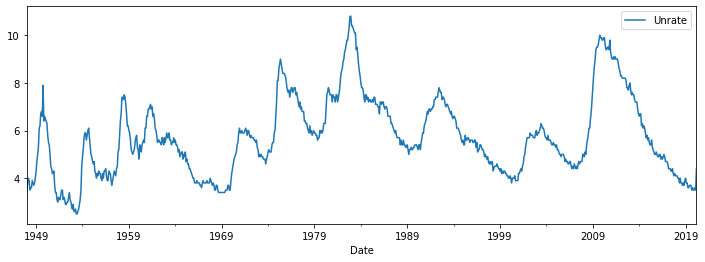

In [16]:
data.plot(figsize=(12,4))
plt.show()

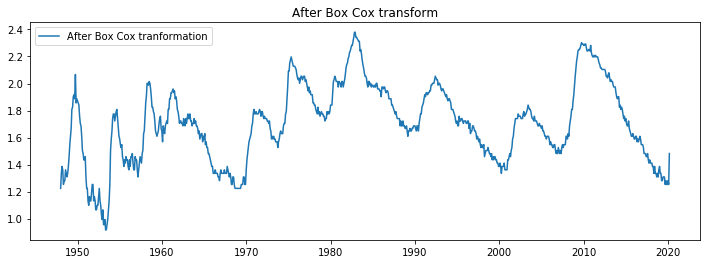

In [18]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Unrate'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

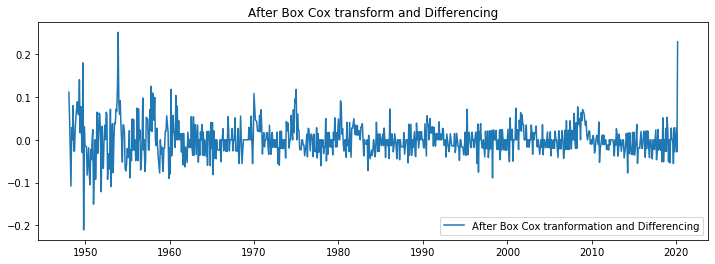

In [19]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(),index=data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and Differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and Differencing')
plt.show()

In [20]:
data_boxcox_diff.dropna(inplace=True)

In [21]:
train_data_boxcox = data_boxcox[:trainlen]
train_data_boxcox_diff = data_boxcox_diff[:trainlen-1]
test_data_boxcox = data_boxcox[trainlen:]
test_data_boxcox_diff = data_boxcox_diff[trainlen-1:]

In [66]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090455
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047124
ar.L12.y   -0.148533
dtype: float64


In [67]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

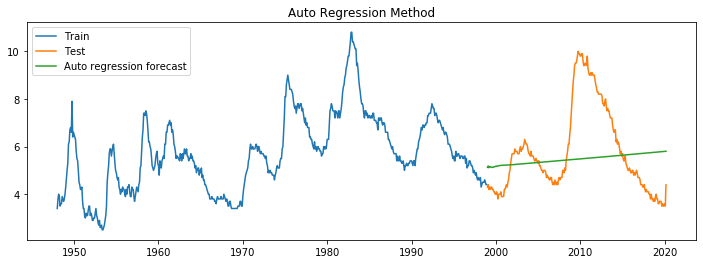

In [68]:
plt.figure(figsize=(12,4))
plt.plot(train['Unrate'], label='Train')
plt.plot(test['Unrate'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_ar['ar_forecast'][test.index.min():])/test['Unrate'])*100,2)

results = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62


In [70]:
y_hat_ar['ar_forecast']['1948-06-01']

4.210203361286766

In [71]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [72]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

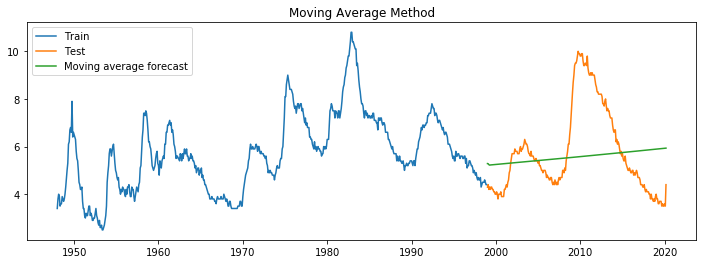

In [73]:
plt.figure(figsize=(12,4))
plt.plot(data['Unrate'][:trainlen], label='Train')
plt.plot(data['Unrate'][trainlen:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [74]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_ma['ma_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26


In [75]:
y_hat_ma['ma_forecast']['1948-06-01']

4.141526587505121

In [76]:
model = ARIMA(train_data_boxcox, order=(12, 1, 5)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const         0.000465
ar.L1.D.y    -0.096072
ar.L2.D.y     0.668357
ar.L3.D.y     0.486785
ar.L4.D.y    -0.464340
ar.L5.D.y    -0.600913
ar.L6.D.y     0.048687
ar.L7.D.y     0.050504
ar.L8.D.y     0.098639
ar.L9.D.y     0.135265
ar.L10.D.y   -0.047409
ar.L11.D.y    0.007766
ar.L12.D.y   -0.072368
ma.L1.D.y     0.126538
ma.L2.D.y    -0.509725
ma.L3.D.y    -0.361550
ma.L4.D.y     0.516532
ma.L5.D.y     0.669887
dtype: float64


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [80]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

In [81]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_arima['arima_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive integrated moving average (ARIM...,2.17,22.04
0,Autoregressive integrated moving average (ARIM...,1.84,23.35


In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(2,1,4), seasonal_order=(2,1,4, 12)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ar.L1       0.601031
ar.L2       0.112457
ma.L1      -0.563681
ma.L2       0.003615
ma.L3       0.067872
ma.L4       0.054923
ar.S.L12   -0.938106
ar.S.L24   -0.511332
ma.S.L12   -0.279517
ma.S.L24   -0.541874
ma.S.L36   -0.394965
ma.S.L48    0.269884
sigma2      0.001491
dtype: float64


In [86]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

In [87]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive integrated moving average (ARIM...,2.17,22.04
0,Autoregressive integrated moving average (ARIM...,1.84,23.35
0,Seasonal autoregressive integrated moving aver...,2.26,22.13
0,Seasonal autoregressive integrated moving aver...,2.26,22.13
